In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import pybedtools
import xarray as xr

In [96]:
ct = 'CA3_Glut'

## long gene RNA

In [97]:
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]
mouse_genes['length'] = mouse_genes['end'] - mouse_genes['start']

In [98]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [104]:
result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index)
result['log2(18mo/2mo)'] = np.log2(result['fc'])
result['-log10(padj)'] = -np.log10(result['fdr'])
result['length'] = result.index.map(mouse_genes.set_index('gene_name')['length'].to_dict())
result.head()

,fc,fdr,log2(18mo/2mo),-log10(padj),length
gene,,,,,
Xkr4,0.835935,1.807901e-30,-0.258537,29.742825,465597
Gm1992,0.705167,5.120208e-01,-0.503964,0.290712,46966
Gm19938,1.609131,1.000000e+00,0.686282,-0.000000,11595
Mrpl15,0.820169,8.416169e-02,-0.286007,1.074886,12533
Lypla1,1.040113,2.188644e-02,0.056741,1.659825,40622


In [105]:
all_deg_result = result[(result['fdr'] < 0.01) & (abs(result['log2(18mo/2mo)']) > 0.3)]
long_deg_result = all_deg_result[all_deg_result['length'] > 100000]

In [106]:
all_long_gene = mouse_genes[mouse_genes['length'] > 100000].shape[0]
all_degs = all_deg_result.shape[0]
all_long_degs = long_deg_result.shape[0]

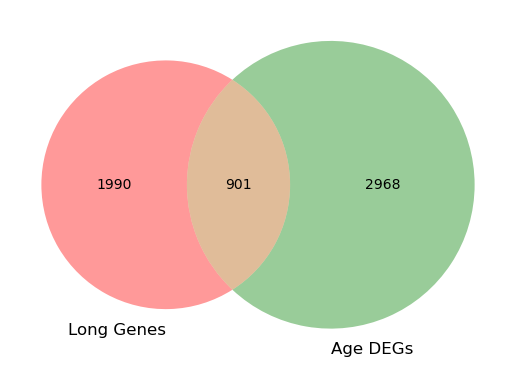

In [107]:
venn2(subsets = (all_long_gene- all_long_degs, all_degs-all_long_degs,all_long_degs), set_labels = ('Long Genes', 'Age DEGs'))
plt.show()

In [113]:
all_long_result = result[result['length'] > 100000]

Text(0.5, 1.0, 'CA3_Glut RNA')

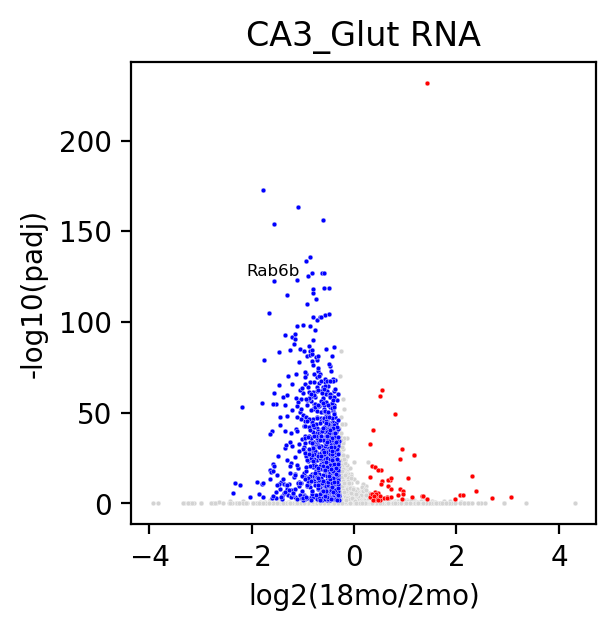

In [125]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 200)
sns.scatterplot(data = all_long_result,
                ax = ax,
                color = 'lightgrey',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = long_deg_result[long_deg_result['fc'] >1],
                ax = ax,
                color = 'red',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = long_deg_result[long_deg_result['fc'] <1],
                ax = ax,
                color = 'blue',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

for i, row in sig_result.iterrows():
    if row['-log10(padj)'] > 100 and (row['log2(18mo/2mo)'] > 2 or row['log2(18mo/2mo)'] < -2):
        ax.text(row['log2(18mo/2mo)'], row['-log10(padj)'], 
                row.name, 
                color='black', fontsize=6)
ax.set_title(f"{ct} RNA")

## plot methylation

In [129]:
gene_meta = pd.read_csv('/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz', 
                        sep = '\t', index_col = 'gene_id')
gene_name_to_id = gene_meta['gene_name'].to_dict()
gene_meta['length'] = gene_meta['end'] - gene_meta['start']

In [130]:
mc_type = 'CGN'
data = xr.open_zarr(f'/data/female-amb/Diff.Result/{mc_type}.Female.AgingMajorType.Anova.Result.zarr')

In [131]:
ct = 'CA3 Glut'

In [148]:
use_ct = ct.replace('/','').replace(' ','_')

In [149]:
gene_result = data.sel(cell_type = ct)['anova_results'].to_pandas()
gene_result['gene_name'] = gene_result.index.map(gene_name_to_id)
gene_result = gene_result.dropna()
gene_result = gene_result.drop_duplicates(keep = 'first')
gene_result = gene_result.set_index('gene_name')
gene_result['mc_change'] = gene_result['18mo']-gene_result['8wk']
gene_result['length'] = gene_result.index.map(gene_meta.set_index('gene_name')['length'].to_dict())
gene_result['-log10(pvalue)'] = -np.log10(gene_result['pvalue'])

In [150]:
all_long_genes =  gene_result[gene_result['length'] > 100000]

In [151]:
sgi_long_genes = all_long_genes[(all_long_genes['pvalue'] < 0.05) & (abs(all_long_genes['mc_change']) > 0.03)]

In [152]:
shared_genes = list(set(long_deg_result.index) & set(sgi_long_genes.index)) 
len(shared_genes)

58

In [153]:
sgi_long_genes = sgi_long_genes.loc[shared_genes]

Text(0.5, 1.0, 'CA3 Glut CGN')

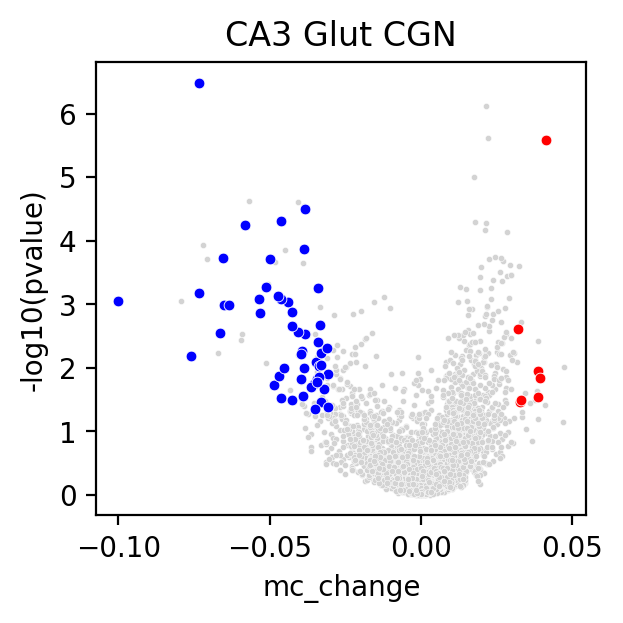

In [154]:
fig, ax = plt.subplots(figsize = (3,3),  dpi = 200, constrained_layout = True)

sns.scatterplot(data = all_long_genes,
            color = 'lightgrey',
            ax = ax,
            s = 5,
            x= 'mc_change',
            y = '-log10(pvalue)')

sns.scatterplot(data = sgi_long_genes[sgi_long_genes['mc_change'] > 0],
                color = 'red',
                ax = ax,
                s = 15,
                legend = False,
                x= 'mc_change',  # Corrected the typo here
                y = '-log10(pvalue)')

sns.scatterplot(data = sgi_long_genes[sgi_long_genes['mc_change'] < 0],
                color = 'blue',
                ax = ax,
                s = 15,
                legend = False,
                x= 'mc_change',  # Corrected the typo here
                y = '-log10(pvalue)')
ax.set_title(f"{ct} {mc_type}")
#ax.set_xlim(-0.1,0.1)
